In [1]:
import torch
import numpy as np
from pandas import factorize, DataFrame
from copy import deepcopy
from matplotlib import pyplot as plt

from uncertain.models.ExplicitFactorizationModel import ExplicitFactorizationModel
from uncertain.models.UncertainWrapper import UncertainWrapper, LinearUncertaintyEstimator
from uncertain.models.multimodelling import EnsembleRecommender, ResampleRecommender
from uncertain.cross_validation import user_based_split, random_train_test_split
from uncertain.interactions import Interactions
from uncertain.models.CPMF import CPMF
from uncertain.models.OrdRec import OrdRec
from uncertain.datasets.movielens import get_movielens_dataset

from utils import evaluate

train = get_movielens_dataset('10M')
train, test = random_train_test_split(train, test_percentage=0.2, random_state=0)
train.gpu()
test.gpu()

MF_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_penalty': 2e-6,
             'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
CPMF_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_base': 3e-6, 'l2_var': 5e-6,
               'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
OrdRec_params = {'embedding_dim': 10, 'n_iter': 50, 'l2_base': 5e-7, 'l2_step': 3e-7,
                 'learning_rate': 0.001, 'batch_size': 2048, 'use_cuda': True}
models = {}

In [2]:
models['Baseline'] = ExplicitFactorizationModel(**MF_params)
models['Baseline'].fit(train)
models['Baseline'].evaluation = evaluate(models['Baseline'], test, train, uncertainty=False)
models['Baseline'].evaluation

FunkSVD: 100%|██████████| 50/50 [04:46<00:00,  5.72s/it, Epoch 50 loss: 0.5839597711500256]


{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0')}

In [3]:
models['User support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(-train.get_user_support(), None))
models['User support'].evaluation = evaluate(models['User support'], test, train, uncertainty=True)
models['User support'].evaluation

{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.7605, 0.7685, 0.7503, 0.7667, 0.7741, 0.7625, 0.7909, 0.7845, 0.7844,
         0.7896, 0.8024, 0.8142, 0.8106, 0.8289, 0.8245, 0.8384, 0.8476, 0.8675,
         0.8896, 0.9422]),
 'Quantile MAP': tensor([0.3143, 0.2193, 0.1867, 0.1617, 0.1404, 0.1258, 0.1196, 0.1060, 0.0963,
         0.0786, 0.0807, 0.0695, 0.0650, 0.0639, 0.0562, 0.0519, 0.0481, 0.0421,
         0.0404, 0.0435]),
 'RRI': tensor([nan, nan, nan, nan, nan, -inf, nan, nan, nan]),
 'Correlation': (tensor(0.0491, device='cuda:0'),
  tensor(0.0651, device='cuda:0')),
 'RPI': tensor(0.2078, device='cuda:0'),
 'Classification': (-0.4936757923262796, 0.5428623934330801)}

In [4]:
models['Item support'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, -train.get_item_support()))
models['Item support'].evaluation = evaluate(models['Item support'], test, train, uncertainty=True)
models['Item support'].evaluation

{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.7886, 0.7789, 0.8117, 0.8078, 0.7796, 0.8190, 0.8153, 0.8106, 0.8056,
         0.8044, 0.8027, 0.8028, 0.8082, 0.7897, 0.8021, 0.8088, 0.8142, 0.8167,
         0.8231, 0.9271]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([0.2349, 0.3602, 0.4418, 0.4950, 0.5321, 0.5594, 0.5839, 0.6060, 0.6226]),
 'Correlation': (tensor(0.0197, device='cuda:0'),
  tensor(0.0231, device='cuda:0')),
 'RPI': tensor(0.0685, device='cuda:0'),
 'Classification': (-0.49436422637633726, 0.5196369330363448)}

In [5]:
models['Item variance'] = UncertainWrapper(models['Baseline'], LinearUncertaintyEstimator(None, train.get_item_variance()))
models['Item variance'].evaluation = evaluate(models['Item variance'], test, train, uncertainty=True)
models['Item variance'].evaluation

{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.7063, 0.7008, 0.7184, 0.7445, 0.7549, 0.7695, 0.7762, 0.7825, 0.7898,
         0.7964, 0.7988, 0.8093, 0.8221, 0.8333, 0.8351, 0.8493, 0.8702, 0.8944,
         0.9122, 1.0014]),
 'Quantile MAP': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'RRI': tensor([0.0252, 0.0361, 0.0529, 0.0478, 0.0494, 0.0513, 0.0519, 0.0484, 0.0481]),
 'Correlation': (tensor(0.1179, device='cuda:0'),
  tensor(0.1010, device='cuda:0')),
 'RPI': tensor(0.4338, device='cuda:0'),
 'Classification': (-0.48921607922258237, 0.5732581753174893)}

In [6]:
models['Ensemble'] = EnsembleRecommender(base_model=models['Baseline'], n_models=10)
models['Ensemble'].fit(train)
models['Ensemble'].evaluation = evaluate(models['Ensemble'], test, train, uncertainty=True)
models['Ensemble'].evaluation

Ensemble: 100%|██████████| 9/9 [1:09:06<00:00, 460.75s/it]


{'RMSE': tensor(0.8045, device='cuda:0'),
 'Precision': tensor([0.1770, 0.1603, 0.1486, 0.1403, 0.1331, 0.1270, 0.1218, 0.1170, 0.1128,
         0.1092], device='cuda:0'),
 'Recall': tensor([0.0186, 0.0333, 0.0463, 0.0575, 0.0675, 0.0768, 0.0856, 0.0936, 0.1012,
         0.1086], device='cuda:0'),
 'Quantile RMSE': tensor([0.6522, 0.6783, 0.6985, 0.7154, 0.7222, 0.7380, 0.7492, 0.7578, 0.7723,
         0.7813, 0.7910, 0.8018, 0.8131, 0.8294, 0.8431, 0.8602, 0.8804, 0.9077,
         0.9483, 1.0416]),
 'Quantile MAP': tensor([0.2321, 0.1794, 0.1590, 0.1296, 0.1209, 0.1073, 0.1004, 0.1016, 0.0974,
         0.0937, 0.0933, 0.0896, 0.0902, 0.0878, 0.0849, 0.0851, 0.0875, 0.0794,
         0.0834, 0.0819]),
 'RRI': tensor([0.0669, 0.1039, 0.1440, 0.1615, 0.1715, 0.1801, 0.1849, 0.1876, 0.1919]),
 'Correlation': (tensor(0.1499, device='cuda:0'),
  tensor(0.1313, device='cuda:0')),
 'RPI': tensor(0.6286, device='cuda:0'),
 'Classification': (-0.48242857414097284, 0.5908773985748289)}

In [7]:
models['Resample'] = ResampleRecommender(base_model=models['Baseline'], n_models=10)
models['Resample'].fit(train)
models['Resample'].evaluation = evaluate(models['Resample'], test, train, uncertainty=True)
models['Resample'].evaluation

Resample: 100%|██████████| 10/10 [1:00:21<00:00, 362.11s/it]


{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.6659, 0.6842, 0.6993, 0.7128, 0.7268, 0.7357, 0.7497, 0.7623, 0.7725,
         0.7834, 0.7935, 0.8069, 0.8167, 0.8312, 0.8538, 0.8658, 0.8898, 0.9159,
         0.9599, 1.0817]),
 'Quantile MAP': tensor([0.2655, 0.1947, 0.1585, 0.1361, 0.1235, 0.1138, 0.1087, 0.1006, 0.0933,
         0.0891, 0.0868, 0.0822, 0.0796, 0.0770, 0.0721, 0.0710, 0.0672, 0.0693,
         0.0612, 0.0530]),
 'RRI': tensor([0.0303, 0.0506, 0.0750, 0.0813, 0.0862, 0.0887, 0.0878, 0.0877, 0.0882]),
 'Correlation': (tensor(0.1622, device='cuda:0'),
  tensor(0.1361, device='cuda:0')),
 'RPI': tensor(0.6744, device='cuda:0'),
 'Classification': (-0.48610762713916633, 0.5927789946137291)}

In [8]:
fold1, fold2 = random_train_test_split(train, random_state=0, test_percentage=0.5)
model_cv = deepcopy(models['Baseline'])
model_cv._initialize(fold1)
model_cv.fit(fold1)
predictions1 = model_cv.predict(fold2.user_ids, fold2.item_ids)
model_cv._initialize(fold2)
model_cv.fit(fold2)
predictions2 = model_cv.predict(fold1.user_ids, fold1.item_ids)
train_errors = torch.cat((torch.abs(fold2.ratings - predictions1), torch.abs(fold1.ratings - predictions2)))
train_errors = Interactions(torch.cat((fold2.user_ids, fold1.user_ids)),
                            torch.cat((fold2.item_ids, fold1.item_ids)),
                            train_errors, num_users=train.num_users, num_items=train.num_items)

In [9]:
models['FCV'] = ExplicitFactorizationModel(**MF_params)
models['FCV'].fit(train_errors)
models['FCV'] = UncertainWrapper(models['Baseline'], models['FCV'])
models['FCV'].evaluation = evaluate(models['FCV'], test, train, uncertainty=True)
models['FCV'].evaluation

FunkSVD: 100%|██████████| 50/50 [04:16<00:00,  5.13s/it, Epoch 50 loss: 0.2564050444280946] 


{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.6553, 0.6087, 0.6231, 0.6425, 0.6646, 0.6819, 0.7077, 0.7197, 0.7372,
         0.7601, 0.7807, 0.7995, 0.8216, 0.8480, 0.8735, 0.9016, 0.9402, 0.9818,
         1.0423, 1.1705]),
 'Quantile MAP': tensor([0.0926, 0.0961, 0.0974, 0.0991, 0.0968, 0.1016, 0.0989, 0.1042, 0.1057,
         0.1057, 0.1104, 0.1085, 0.1083, 0.1122, 0.1115, 0.1119, 0.1123, 0.1185,
         0.1121, 0.0998]),
 'RRI': tensor([ 0.0127,  0.0214,  0.0204,  0.0120,  0.0087,  0.0065,  0.0050, -0.0002,
         -0.0048]),
 'Correlation': (tensor(0.2411, device='cuda:0'),
  tensor(0.2258, device='cuda:0')),
 'RPI': tensor(0.9213, device='cuda:0'),
 'Classification': (-0.4747804869802457, 0.650652717921

In [10]:
MF_params['embedding_dim'] = 0
models['BCV'] = ExplicitFactorizationModel(**MF_params)
models['BCV'].fit(train_errors)
models['BCV'] = UncertainWrapper(models['Baseline'], models['BCV'])
models['BCV'].evaluation = evaluate(models['BCV'], test, train, uncertainty=True)
models['BCV'].evaluation

Linear recommender: 100%|██████████| 50/50 [04:14<00:00,  5.09s/it, Epoch 50 loss: 0.26964049199550755]


{'RMSE': tensor(0.8115, device='cuda:0'),
 'Precision': tensor([0.1698, 0.1537, 0.1421, 0.1339, 0.1274, 0.1217, 0.1171, 0.1126, 0.1087,
         0.1052], device='cuda:0'),
 'Recall': tensor([0.0176, 0.0316, 0.0433, 0.0539, 0.0637, 0.0728, 0.0813, 0.0890, 0.0966,
         0.1036], device='cuda:0'),
 'Quantile RMSE': tensor([0.5096, 0.5595, 0.5959, 0.6289, 0.6524, 0.6770, 0.7000, 0.7189, 0.7418,
         0.7622, 0.7851, 0.8122, 0.8315, 0.8540, 0.8841, 0.9178, 0.9481, 0.9970,
         1.0649, 1.2159]),
 'Quantile MAP': tensor([0.1918, 0.1670, 0.1530, 0.1349, 0.1306, 0.1200, 0.1167, 0.1129, 0.1072,
         0.0999, 0.0967, 0.0967, 0.0893, 0.0871, 0.0841, 0.0785, 0.0691, 0.0675,
         0.0563, 0.0441]),
 'RRI': tensor([-0.0030, -0.0076, -0.0151, -0.0255, -0.0298, -0.0337, -0.0369, -0.0442,
         -0.0464]),
 'Correlation': (tensor(0.2841, device='cuda:0'),
  tensor(0.2516, device='cuda:0')),
 'RPI': tensor(1.0464, device='cuda:0'),
 'Classification': (-0.4660864275519436, 0.672506091375

In [11]:
models['CPMF'] = CPMF(**CPMF_params)
models['CPMF'].fit(train)
models['CPMF'].evaluation = evaluate(models['CPMF'], test, train, uncertainty=True)
models['CPMF'].evaluation

CPMF: 100%|██████████| 50/50 [06:57<00:00,  8.34s/it, Epoch 50 loss: 0.3482005226206285] 


{'RMSE': tensor(0.8096, device='cuda:0'),
 'Precision': tensor([0.1580, 0.1415, 0.1293, 0.1224, 0.1166, 0.1116, 0.1076, 0.1039, 0.1007,
         0.0978], device='cuda:0'),
 'Recall': tensor([0.0154, 0.0274, 0.0369, 0.0463, 0.0547, 0.0625, 0.0699, 0.0770, 0.0838,
         0.0901], device='cuda:0'),
 'Quantile RMSE': tensor([0.4730, 0.5496, 0.5928, 0.6236, 0.6513, 0.6775, 0.7021, 0.7274, 0.7500,
         0.7677, 0.7953, 0.8113, 0.8354, 0.8625, 0.8866, 0.9196, 0.9506, 0.9974,
         1.0553, 1.1871]),
 'Quantile MAP': tensor([0.2161, 0.1627, 0.1379, 0.1104, 0.1005, 0.0878, 0.0813, 0.0755, 0.0754,
         0.0707, 0.0712, 0.0711, 0.0695, 0.0735, 0.0796, 0.0770, 0.0814, 0.0920,
         0.1014, 0.1204]),
 'RRI': tensor([0.0624, 0.0904, 0.1016, 0.1067, 0.1084, 0.1111, 0.1147, 0.1183, 0.1219]),
 'Correlation': (tensor(0.2803, device='cuda:0'),
  tensor(0.2536, device='cuda:0')),
 'RPI': tensor(1.0624, device='cuda:0'),
 'Classification': (-0.4658520808893942, 0.6729670303209385)}

In [12]:
factor = factorize(train.ratings.cpu(), sort=True)
rating_labels = torch.from_numpy(factor[1].astype(np.float64)).cuda()
train.ratings = torch.from_numpy(factor[0]).cuda()

models['OrdRec'] = OrdRec(rating_labels, **OrdRec_params)
models['OrdRec'].fit(train)
models['OrdRec'].evaluation = evaluate(models['OrdRec'], test, train, uncertainty=True)
models['OrdRec'].evaluation

OrdRec: 100%|██████████| 50/50 [08:57<00:00, 10.74s/it, Epoch 50 loss: -0.41968950549903844]


{'RMSE': tensor(0.9778, device='cuda:0', dtype=torch.float64),
 'Precision': tensor([0.1823, 0.1657, 0.1530, 0.1436, 0.1353, 0.1287, 0.1230, 0.1182, 0.1139,
         0.1098], device='cuda:0'),
 'Recall': tensor([0.0180, 0.0330, 0.0459, 0.0571, 0.0667, 0.0755, 0.0834, 0.0910, 0.0979,
         0.1045], device='cuda:0'),
 'Quantile RMSE': tensor([0.9115, 0.9781, 0.9599, 0.9763, 0.9586, 0.9395, 0.9340, 0.8966, 0.9156,
         0.9348, 0.9401, 0.9481, 0.9486, 0.9468, 0.9356, 0.9876, 1.0305, 1.0806,
         1.0977, 1.1851]),
 'Quantile MAP': tensor([0.1534, 0.1887, 0.1581, 0.1488, 0.1377, 0.1266, 0.1184, 0.1095, 0.1027,
         0.0967, 0.0944, 0.0932, 0.1048, 0.1047, 0.0955, 0.0890, 0.0768, 0.0673,
         0.0683, 0.0626]),
 'RRI': tensor([0.0541, 0.0852, 0.0934, 0.1053, 0.1149, 0.1174, 0.1215, 0.1216, 0.1269]),
 'Correlation': (tensor(0.1416, device='cuda:0', dtype=torch.float64),
  tensor(0.2498, device='cuda:0', dtype=torch.float64)),
 'RPI': tensor(0.2970, device='cuda:0', dtype=torch

In [21]:
keys = ['Baseline', 'Ensemble', 'CPMF', 'OrdRec']
rmse = [models[key].evaluation['RMSE'].item() for key in keys]
DataFrame(rmse, index=keys, columns=['RMSE'])

,RMSE
Baseline,0.811509
Ensemble,0.804527
CPMF,0.809598
OrdRec,0.977780


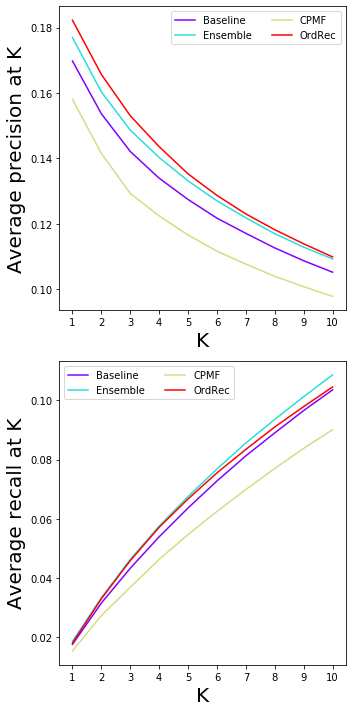

In [22]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
f, ax = plt.subplots(nrows=2, figsize=(5, 10))
for key in keys:
    c = next(color)
    ax[0].plot(np.arange(1, 11), models[key].evaluation['Precision'].cpu().detach().numpy(), '-', color=c, label=key)
    ax[1].plot(np.arange(1, 11), models[key].evaluation['Recall'].cpu().detach().numpy(), '-', color=c, label=key)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', Fontsize=20)
ax[0].set_ylabel('Average precision at K', Fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xticklabels(np.arange(1, 11))
ax[1].set_xlabel('K', Fontsize=20)
ax[1].set_ylabel('Average recall at K', Fontsize=20)
ax[1].legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/10M/precision_recall.pdf')

In [23]:
keys = list(models.keys())[1:]
out = DataFrame(np.zeros((3, 9)), index=['RPI', 'Pearson', 'Spearman'], columns=keys)
for key in keys:
    out[key] = (models[key].evaluation['RPI'].item(), 
                models[key].evaluation['Correlation'][0].item(), 
                models[key].evaluation['Correlation'][1].item())
out.T

,RPI,Pearson,Spearman
User support,0.207827,0.049118,0.065132
Item support,0.068523,0.019707,0.023072
Item variance,0.433757,0.117903,0.101049
Ensemble,0.628628,0.149920,0.131296
Resample,0.674402,0.162180,0.136051
FCV,0.921302,0.241088,0.225819
BCV,1.046367,0.284094,0.251632
CPMF,1.062436,0.280302,0.253597
OrdRec,0.296997,0.141634,0.249846


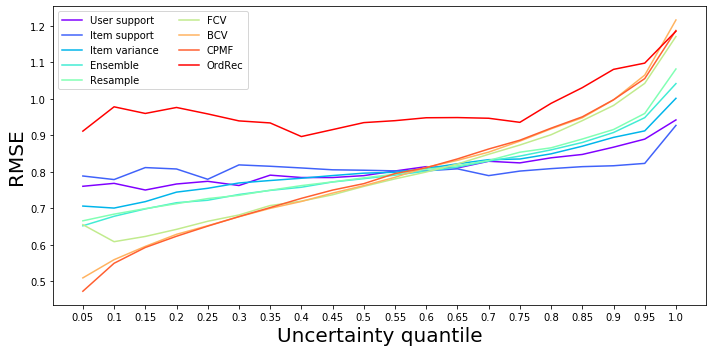

In [24]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile RMSE'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('RMSE', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/10M/RMSE_uncertainty.pdf')

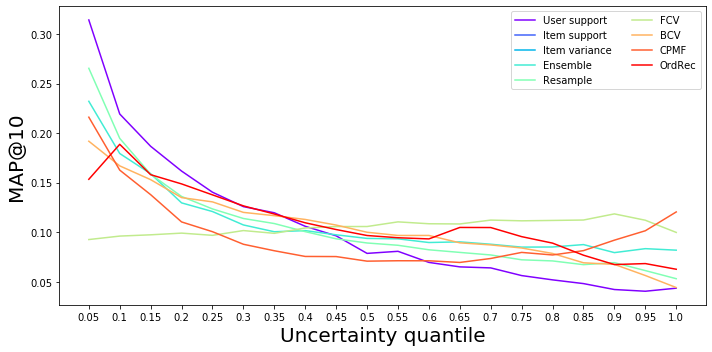

In [25]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(1, 21), models[key].evaluation['Quantile MAP'], '-', color=c, label=key)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels(np.round(np.linspace(start=0.05, stop=1, num=20, endpoint=True), 2))
ax.set_xlabel('Uncertainty quantile', Fontsize=20)
ax.set_ylabel('MAP@10', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/10M/MAP_uncertainty.pdf')

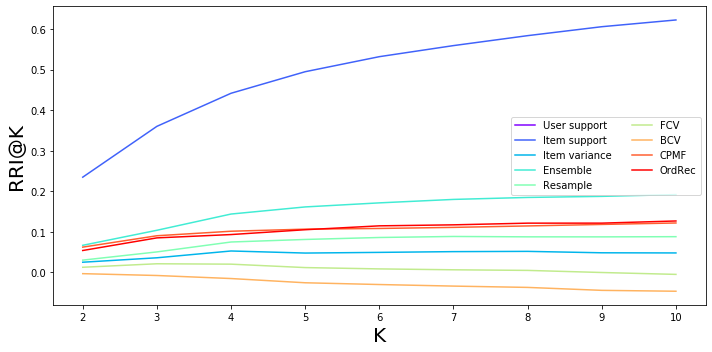

In [26]:
color=iter(plt.cm.rainbow(np.linspace(0, 1, 9)))
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    c = next(color)
    ax.plot(np.arange(2, 11), models[key].evaluation['RRI'], '-', color=c, label=key)
ax.set_xlabel('K', Fontsize=20)
ax.set_ylabel('RRI@K', Fontsize=20)
ax.legend(ncol=2)
f.tight_layout()
f.savefig('Empirical study/10M/URI.pdf')

In [27]:
results = DataFrame((np.zeros((2, 9))), index=['Likelihood', 'AUC'], columns=keys)
for key in keys:
    results[key] = models[key].evaluation['Classification']
results.T

,Likelihood,AUC
User support,-0.493676,0.542862
Item support,-0.494364,0.519637
Item variance,-0.489216,0.573258
Ensemble,-0.482429,0.590877
Resample,-0.486108,0.592779
FCV,-0.474780,0.650653
BCV,-0.466086,0.672506
CPMF,-0.465852,0.672967
OrdRec,-0.527970,0.579145
